### 导入库

In [1]:
import meshio
import numpy as np
import matplotlib.pyplot as plt
from math import *
import scipy.constants as cn
%matplotlib inline

### 网格信息读取

In [2]:
mesh = meshio.read("horn-antenna-ABC-circle.msh", file_format = ("gmsh"))

# 节点坐标提取
nodes = mesh.points
Nn = nodes.shape[0]
x = nodes[:, 0]; y = nodes[:, 1]

# 物理组件编号提取
phy_line = mesh.cell_data_dict["gmsh:physical"]["line"]
phy_triangle = mesh.cell_data_dict["gmsh:physical"]["triangle"]

# 单元编码提取
ele_line = mesh.cells_dict["line"]
ele_triangle = mesh.cells_dict["triangle"]

# ele_filter 为单元筛选函数
def ele_filter(ele_data, phy_data, num_phy):
    num = np.where(phy_data == num_phy)
    count = len(num[0])
    elements = ele_data[num[0], :].T
    return (count, elements)

### 刚度矩阵计算

In [3]:
# stiffness_matrix  函数用于刚度矩阵方程的计算
def stiffness_matrix(Ne, n, K, B, alphax, alphay, beta, f):
    Ke = np.zeros((3, 3), dtype = complex)
    Be = np.zeros((3), dtype = complex)
    be = np.zeros((3), dtype = float)
    ce = np.zeros((3), dtype = float)
    
    for e in range(0, Ne):
        be[0] = y[n[1, e]]-y[n[2, e]]
        be[1] = y[n[2, e]]-y[n[0, e]]
        be[2] = y[n[0, e]]-y[n[1, e]]
        ce[0] = x[n[2, e]]-x[n[1, e]]
        ce[1] = x[n[0, e]]-x[n[2, e]]
        ce[2] = x[n[1, e]]-x[n[0, e]]
        # 三角单元面积
        Deltae = abs((be[0]*ce[1]-be[1]*ce[0]))/2.
        
        # 单元刚度矩阵计算
        for i in range(0, 3):
            for j in range(0, 3):
                if (i == j):
                    delta_ij = 1
                else:
                    delta_ij = 0
                Ke[i][j] = (alphax*be[i]*be[j]+alphay*ce[i]*ce[j])/(4.*Deltae)\
                        +Deltae*beta*(1+delta_ij)/12.
            Be[i] = Deltae*f/3.
        # 单元刚度矩阵组合至总刚度矩阵
        for i in range(0, 3):
            for j in range(0, 3):
                K[n[i][e]][n[j][e]] = K[n[i][e]][n[j][e]]+Ke[i][j]
            B[n[i][e]] = B[n[i][e]]+Be[i]
    return (K, B)

In [4]:
# 刚度矩阵初始化
K = np.zeros((Nn, Nn), dtype = complex)
b = np.zeros((Nn), dtype = complex)

# 基本参数
lambda0 = cn.c/6e9
k0 = 2*pi/lambda0
ky = pi/0.03
kx = sqrt(k0**2-ky**2)

In [5]:
# 空气处刚度矩阵方程计算
mur0 = 1; epsilon0 = 1
alphax = 1/mur0; alphay = 1/mur0; beta = -k0**2*epsilon0; f = 0
(Ne, n) = ele_filter(ele_triangle, phy_triangle, 9)
(K, b) = stiffness_matrix(Ne, n, K, b, alphax, alphay, beta, f)
(Ne, n) = ele_filter(ele_triangle, phy_triangle, 10)
(K, b) = stiffness_matrix(Ne, n, K, b, alphax, alphay, beta, f)

### 入射场边界条件处理

In [6]:
# Robin_boundary 函数用于处理 Robin 边界条件 
def Robin_boundary(Ns, ns, K, B, gamma, q):
    Ks = np.zeros((2, 2), dtype = complex)

    for s in range(0, Ns):
        i = ns[0][s]
        j = ns[1][s]
        # 线段单元长度
        ls = sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)

        # 单元刚度矩阵元素
        Ks[0][0] = gamma[s]*ls/3
        Ks[0][1] = gamma[s]*ls/6
        Ks[1][0] = Ks[0][1]
        Ks[1][1] = Ks[0][0]
        
        # 单元刚度矩阵组合至总刚度矩阵
        for i in range(0, 2):
            for j in range(0, 2):
                K[ns[i][s]][ns[j][s]] = K[ns[i][s]][ns[j][s]]+Ks[i][j]
            B[ns[i][s]] = B[ns[i][s]]+q[s]*ls/2

    return (K, B)

In [7]:
E0 = 2

(Ns, ns) = ele_filter(ele_line, phy_line, 12)
gamma = np.zeros((Ns), dtype = complex)
q = np.zeros((Ns), dtype = complex)
alpha = alphax; gamma[0:Ns] = alpha*1j*kx; q[0:Ns] = 2*alpha*1j*kx*E0*np.exp(-1j*kx*(x[ns[0][0:Ns]]+x[ns[1][0:Ns]])/2)
(K, b) = Robin_boundary(Ns, ns, K, b, gamma, q)

### 二阶 Sommerfeld 辐射条件处理

In [8]:
# Sommerfeld_condition 函数用于处理二阶 Sommerfeld 辐射边界条件 
def Sommerfeld_condition(Ns, ns, K, B, gamma1, gamma2, q):
    Ks = np.zeros((2, 2), dtype = complex)
    
    for s in range(0, Ns):
        i = ns[0][s]
        j = ns[1][s]
        # 线段单元长度
        ls = sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)

        # 单元刚度矩阵元素
        Ks[0][0] = gamma1[s]*ls/3-gamma2[s]/ls
        Ks[0][1] = gamma1[s]*ls/6+gamma2[s]/ls
        Ks[1][0] = Ks[0][1]
        Ks[1][1] = Ks[0][0]
        
        # 单元刚度矩阵组合至总刚度矩阵
        for i in range(0, 2):
            for j in range(0, 2):
                K[ns[i][s]][ns[j][s]] = K[ns[i][s]][ns[j][s]]+Ks[i][j]
            B[ns[i][s]] = B[ns[i][s]]+q[s]*ls/2

    return (K, B)

In [9]:
# 吸收边界条件

(Ns, ns) = ele_filter(ele_line, phy_line, 11)
gamma1 = np.zeros((Ns), dtype = complex)
gamma2 = np.zeros((Ns), dtype = complex)
q = np.zeros((Ns), dtype = complex)
R = 0.3; kappa = 1/R
gamma1[0:Ns] = alpha*(1j*k0+kappa/2-1j*kappa**2/(8*(1j*kappa-k0))); gamma2[0:Ns] = (-1j*alpha)/(2*1j*kappa-2*k0)
q[0:Ns] = 0
(K, b) = Sommerfeld_condition(Ns, ns, K, b, gamma1, gamma2, q)

### PEC 边界条件处理

In [10]:
# Dirichlet_boundary 函数用于处理 Dirichlet 边界条件
def Dirichlet_boundary(Nn, Nl, nd, K, B, p):
    for i in range(0, Nl):
        B[nd[i]] = p
        K[nd[i]][nd[i]] = 1

        for j in range(0, Nn):
            if j != nd[i]:
                B[j] = B[j]-K[j][nd[i]]*p
                K[j][nd[i]] = 0
                K[nd[i]][j] = 0
    
    return (K, B)

In [11]:
# PEC 边界条件处理
(Nl, nd) = ele_filter(ele_line, phy_line, 13)
nd = np.unique(nd)
Nl = len(nd)
(K, b) = Dirichlet_boundary(Nn, Nl, nd, K, b, 0)

### 求解刚度矩阵方程

In [12]:
Ez = np.linalg.solve(K, b)
Ez = np.real(Ez)

### 后处理

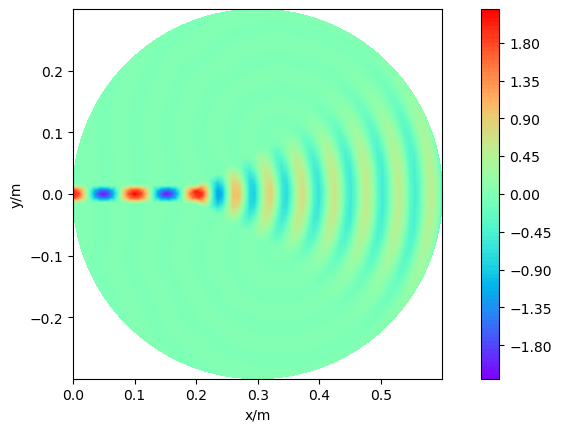

In [13]:
plt.tricontourf(x, y, Ez, levels = 100, cmap = 'rainbow')
# plt.triplot(x, y, 'g-', linewidth=0.1)
plt.colorbar()
plt.axis('image')
plt.xlabel('x/m')
plt.ylabel('y/m')
plt.savefig('ciircle_ABC_order2.png', format = 'png')